In [22]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
#!pip install mplfinance
import mplfinance as mpf
from mplfinance.original_flavor import candlestick2_ochl, candlestick_ohlc
import numpy as np
import pandas as pd
import time
import shutil
import os
import sys
from SR import *


#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#import keras
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import keras.backend as K

from keras_OneCycle import OneCycle

In [7]:
# Multiple input files
input_size = 432
n_steps = 10
x_train = []
y_train = np.empty(1)
for i in ["M15", "M30", "H1", "H4", "D"]:
    data = pd.read_csv("data/eurusd/eurusd_" + i + ".csv")

    for i in ["r1", "r2", "r3", "s1", "s2", "s3"]:
      data[i] = np.nan


    # get index of signals
    signals = data.loc[(data["1"] == 1) | (data["1"] == -1)].index

    # create training_data based on signals
    temp = [data[s-input_size+1:s+1] for s in signals if s > input_size]


    # create HOLD training data
    np.random.seed(42)
    temp_hold_signals = data.loc[(data["1"] != 1) & (data["1"] != -1)].index
    temp_non_signal_index = np.random.choice(data.loc[(data["1"] != 1) & (data["1"] != -1)].index, size=len(signals)//2)
    temp_non_signal_index = temp_non_signal_index[temp_non_signal_index > input_size]

    temp_hold = [data[s-input_size+1:s+1] for s in temp_non_signal_index if s > input_size]
    x_train = x_train + temp + temp_hold
    y_train = np.append(y_train, data["1"][signals][data["1"][signals].index > input_size].values)
    y_train = np.append(y_train, np.zeros(len(temp_hold)))
    y_train[y_train == -1] = 2  # change sell value to positive, 0=hold, 1=buy, 2=sell
y_train = y_train[1:]   # get rid of the initial "empty" position

In [ ]:
#single input file
input_size = 432
n_steps = 10
data = pd.read_csv("data/eurusd/eurusd_H1.csv")

for i in ["r1", "r2", "r3", "s1", "s2", "s3"]:
    data[i] = np.nan


# get index of signals
signals = data.loc[(data["1"] == 1) | (data["1"] == -1)].index

# create training_data based on signals
x_train = [data[s-input_size+1:s+1] for s in signals if s > input_size]


# create HOLD training data
np.random.seed(42)
hold_signals = data.loc[(data["1"] != 1) & (data["1"] != -1)].index
non_signal_index = np.random.choice(data.loc[(data["1"] != 1) & (data["1"] != -1)].index, size=len(signals)//2)
non_signal_index = non_signal_index[non_signal_index > input_size]

x_train_hold = [data[s-input_size+1:s+1] for s in non_signal_index if s > input_size]
x_train = x_train + x_train_hold
y_train = np.append(data["1"][signals][data["1"][signals].index > input_size].values, np.zeros(len(x_train_hold)))
y_train[y_train == -1] = 2  # change sell value to positive, 0=hold, 1=buy, 2=sell

In [4]:
%%time
# get 3 above and 3 below last close price

for i, df in enumerate(x_train):
    df = sr(df, input_size).drop(columns=["1", "s", "r"])
    
    # 3 above and 3 below last close price
    levels = np.array(sorted([l for l in df.columns if type(l) == np.float64]))
    last_close = df.close[-1]
    r3 = levels[(levels - last_close) > 0][:3]
    s3 = levels[(levels - last_close) < 0][-3:]
    
    # change resistance names
    for l, name in zip(r3, ["r1", "r2", "r3"]):
        df[name] = df[l]

    # change support names
    for l, name in zip(s3, ["s1", "s2", "s3"]):
        #df.rename(columns = {l : name}, errors="raise", inplace=True)
        df[name] = df[l]


    # remove all other levels columns
    levels = np.array(sorted([l for l in df.columns if type(l) == np.float64]))
    x_train[i] = df.drop(columns=levels).fillna(0)[-100:]

<timed exec>:9: RuntimeWarning: invalid value encountered in greater
<timed exec>:10: RuntimeWarning: invalid value encountered in less


CPU times: user 17min 5s, sys: 2.86 s, total: 17min 8s
Wall time: 17min 13s


In [31]:
# reshaping the array from 3D 
# matrice to 2D matrice. 
#x_train_reshaped = x_train.reshape(x_train.shape[0], -1) 
  
# saving reshaped array to file. 
#np.savetxt("x_train.txt", x_train_reshaped) 
  
# retrieving data from file. 
x_train = np.loadtxt("x_train.txt") 
  
# This loadedArr is a 2D array, therefore 
# we need to convert it to the original 
# array shape.reshaping to get original 
# matrice with original shape. 
x_train = x_train.reshape( 
    x_train.shape[0], x_train.shape[1] // 73, 73) 

In [ ]:
x_train

In [47]:
# If you like to speed up training process with GPU, first install PlaidML and then uncomment the following line.
# Otherwise it will fallback to tensorflow.

# Enter the number of samples, training + validation
nb_train_samples = round(len(x_train)*.8)
nb_val_samples = round(len(x_train)*.2)

# We have 3 classes, buy sell, and hold
n_features = x_train[0].shape[1]
num_classes = 3
lr = 0.001

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(0.5)(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(0.5)(conv2)

    conv3 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(0.5)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def make_model1(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", data_format="channels_last")(input_layer)
    conv1 = keras.layers.AveragePooling2D(pool_size=(2,2), padding="same")(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(0.5)(conv1)

    conv2 = keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", data_format="channels_last")(conv1)
    conv2 = keras.layers.AveragePooling2D(pool_size=(2,2), padding="same")(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(0.5)(conv2)

    conv3 = keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", data_format="channels_last")(conv2)
    conv3 = keras.layers.AveragePooling2D(pool_size=(2,2), padding="same")(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(0.5)(conv3)

    gap = keras.layers.GlobalAveragePooling2D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def make_model2(input_shape):
    model = M.Sequential()
    model.add(L.LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(L.Dense(1))
    
    return model

def make_model3(input_shape):
    model = M.Sequential()
    model.add(L.Input(input_shape))
    model.add(L.Dense(100, activation="selu"))
    model.add(L.BatchNormalization())
    
    model.add(L.Dense(100, activation="selu"))
    model.add(L.BatchNormalization())
    
    model.add(L.Dense(100, activation="selu"))
    model.add(L.BatchNormalization())
    
    model.add(L.Dense(3, activation="softmax"))
    
    return model
    

model = make_model(input_shape=x_train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)
#model.summary()

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
#model.save("my_model")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_model")

In [48]:
%%time
epochs = 500
batch_size = 8

callbacks = [
    OneCycle(min_lr=7e-6, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01, training_iterations=np.ceil(((x_train.shape[0]*epochs)/(batch_size)))),
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

opt = keras.optimizers.SGD()
losses = keras.losses.SparseCategoricalCrossentropy()
model.compile(
    optimizer=opt,
    loss=losses,
    metrics=["accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=2,
)

Epoch 1/500
294/294 - 6s - loss: 1.1521 - accuracy: 0.3363 - val_loss: 1.0294 - val_accuracy: 0.4855
Epoch 2/500
294/294 - 5s - loss: 1.0818 - accuracy: 0.3926 - val_loss: 1.0076 - val_accuracy: 0.4923
Epoch 3/500
294/294 - 5s - loss: 1.0726 - accuracy: 0.3973 - val_loss: 1.0591 - val_accuracy: 0.4872
Epoch 4/500
294/294 - 6s - loss: 1.0672 - accuracy: 0.4062 - val_loss: 1.2025 - val_accuracy: 0.4855
Epoch 5/500
294/294 - 5s - loss: 1.0759 - accuracy: 0.3960 - val_loss: 1.2174 - val_accuracy: 0.4770
Epoch 6/500
294/294 - 6s - loss: 1.0628 - accuracy: 0.4156 - val_loss: 1.2913 - val_accuracy: 0.4702
Epoch 7/500
294/294 - 5s - loss: 1.0566 - accuracy: 0.4105 - val_loss: 1.4653 - val_accuracy: 0.4549
Epoch 8/500
294/294 - 5s - loss: 1.0523 - accuracy: 0.4088 - val_loss: 1.5544 - val_accuracy: 0.4293
Epoch 9/500
294/294 - 6s - loss: 1.0499 - accuracy: 0.4186 - val_loss: 1.8336 - val_accuracy: 0.3220
Epoch 10/500
294/294 - 5s - loss: 1.0553 - accuracy: 0.3964 - val_loss: 1.8323 - val_accura

KeyboardInterrupt: 

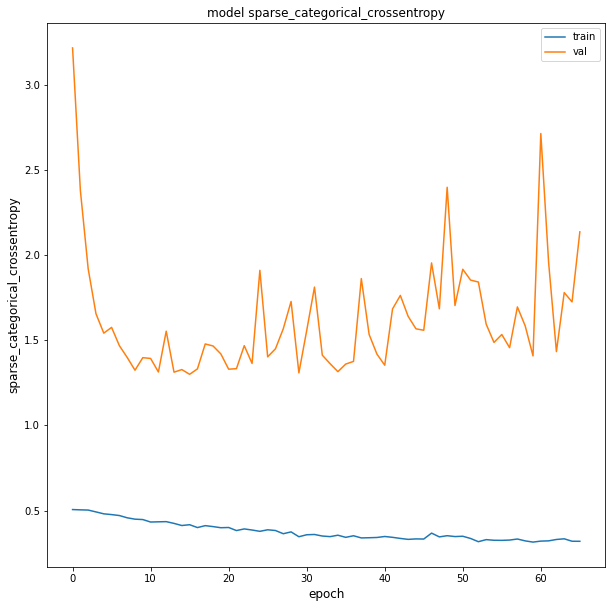

In [26]:
metric = "sparse_categorical_crossentropy"
plt.figure(figsize=(10,10))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
model.save("model_80pct")

INFO:tensorflow:Assets written to: model_80pct/assets


# Create Test Set

In [37]:
input_size = 432
n_steps = 10
data = pd.read_csv("data/gbpjpy/gbpjpy_H4.csv")

for i in ["r1", "r2", "r3", "s1", "s2", "s3"]:
    data[i] = np.nan


# get index of signals
signals = data.loc[(data["1"] == 1) | (data["1"] == -1)].index

# create training_data based on signals
x_test = [data[s-input_size+1:s+1] for s in signals if s > input_size]


# create HOLD training data
np.random.seed(42)
hold_signals = data.loc[(data["1"] != 1) & (data["1"] != -1)].index
non_signal_index = np.random.choice(data.loc[(data["1"] != 1) & (data["1"] != -1)].index, size=len(signals)//2)
non_signal_index = non_signal_index[non_signal_index > input_size]

x_test_hold = [data[s-input_size+1:s+1] for s in non_signal_index if s > input_size]
x_test = x_test + x_test_hold
y_test = np.append(data["1"][signals][data["1"][signals].index > input_size].values, np.zeros(len(x_test_hold)))
y_test[y_test == -1] = 2  # change sell value to positive, 0=hold, 1=buy, 2=sell

In [38]:
# get 3 above and 3 below last close price

for i, df in enumerate(x_test):
    df = sr(df, input_size).drop(columns=["1", "s", "r"])
    
    # 3 above and 3 below last close price
    levels = np.array(sorted([l for l in df.columns if type(l) == np.float64]))
    last_close = df.close[-1]
    r3 = levels[(levels - last_close) > 0][:3]
    s3 = levels[(levels - last_close) < 0][-3:]
    
    # change resistance names
    for l, name in zip(r3, ["r1", "r2", "r3"]):
        df[name] = df[l]

    # change support names
    for l, name in zip(s3, ["s1", "s2", "s3"]):
        #df.rename(columns = {l : name}, errors="raise", inplace=True)
        df[name] = df[l]


    # remove all other levels columns
    levels = np.array(sorted([l for l in df.columns if type(l) == np.float64]))
    x_test[i] = df.drop(columns=levels).fillna(0)[-100:]

<ipython-input-38-aaeb1d3e7962>:9: RuntimeWarning: invalid value encountered in greater
  r3 = levels[(levels - last_close) > 0][:3]
<ipython-input-38-aaeb1d3e7962>:10: RuntimeWarning: invalid value encountered in less
  s3 = levels[(levels - last_close) < 0][-3:]


In [39]:
# select which data to use
#data = data[["index","open", "high", "low", "close", "1"]]


# convert from dataframe to numpy array    
for i, df in enumerate(x_test):
    x_test[i] = df.to_numpy()
x_test = np.array(x_test)

In [40]:
model.evaluate(x_test, y_test, batch_size=128)

6/6 [==============================] - 0s 35ms/step - loss: 1.0018 - mae: 1.0018


[1.0017613172531128, 1.0017613172531128]

In [25]:
mpf.plot(pd.DataFrame(x_train[0]))

TypeError: Expect data.index as DatetimeIndex